<h1 style="text-align: center"><b> Diabetes Prediction </b></h1>
<h2 style="text-align: center"> Machine Learning </h2>

In [6]:
pip install imbalanced-learn
pip install --upgrade scikit-learn

#UNCOMMENT IF YOU DID NOT DOWNLOAD THEM ALREADY

SyntaxError: invalid syntax (993326800.py, line 1)

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import sklearn.neighbors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.decomposition import PCA


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, make_scorer, fbeta_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

def confusion(y_test: np.array, y_pred: np.array, labels):
    matrix = confusion_matrix(y_test, y_pred)
    df = pd.DataFrame(matrix,columns=['predicted '+i for i in labels], index=['actual '+i for i in labels])
    df.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
    return df

ModuleNotFoundError: No module named 'imblearn'

In [37]:
data = pd.read_csv("diabetes_prediction_dataset.csv")

In [70]:
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


<h3 style="text-align: center"> Data Preprocessing </h3>

In [71]:
# Assuming your DataFrame is called 'df' and the column is 'gender'
value_counts = data['gender'].value_counts()
#Encode the data
data = pd.read_csv("diabetes_prediction_dataset.csv")

one_hot_encoded = pd.get_dummies(data['gender'])
data = pd.concat([one_hot_encoded, data], axis=1)
data = data.drop("gender", axis=1)

one_hot_encoded = pd.get_dummies(data['smoking_history'])
data = pd.concat([one_hot_encoded, data], axis=1)
data = data.drop("smoking_history",axis=1)

#normalize each feature by dividing by the maximum
data = data / data.max()


In [72]:
data.head()

,No Info,current,ever,former,never,not current,Female,Male,Other,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.000,0.0,1.0,0.263246,0.733333,0.466667,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.675,0.0,0.0,0.285505,0.733333,0.266667,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.350,0.0,0.0,0.285505,0.633333,0.526667,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.450,0.0,0.0,0.245062,0.555556,0.516667,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.950,1.0,1.0,0.210471,0.533333,0.516667,0.0


We now want to check if there are duplicate rows, if so, we will drop them as this will impact our model's prediction. Indeed, if the test data contains data that the model has already been trained on, then the model will have a high accuracy, but we will not know how it would perform with data it has never seen.

In [73]:
isnasum = data.isna().sum()
print("Number of duplicates:", data.duplicated().sum(), "\nNumber of NaN values:",isnasum.sum())

Number of duplicates: 3854 
Number of NaN values: 0


We see that there are quite a few duplicates. We will consider that they are indeed all different persons (which is plausible considering the features), but this means we must deviate from the usual strategy of dividing the dataset into different test and train sets, by making sure all the duplicates are either in the test set, or the train set, bu never in both. This should prevent testing the model on data it has already seen, and prevent the risk of high accuracy score if the model overfits the testing data. 

Now, we will look at the correlation of each features of the data set, as well as the distribution of the data inside the dataset.

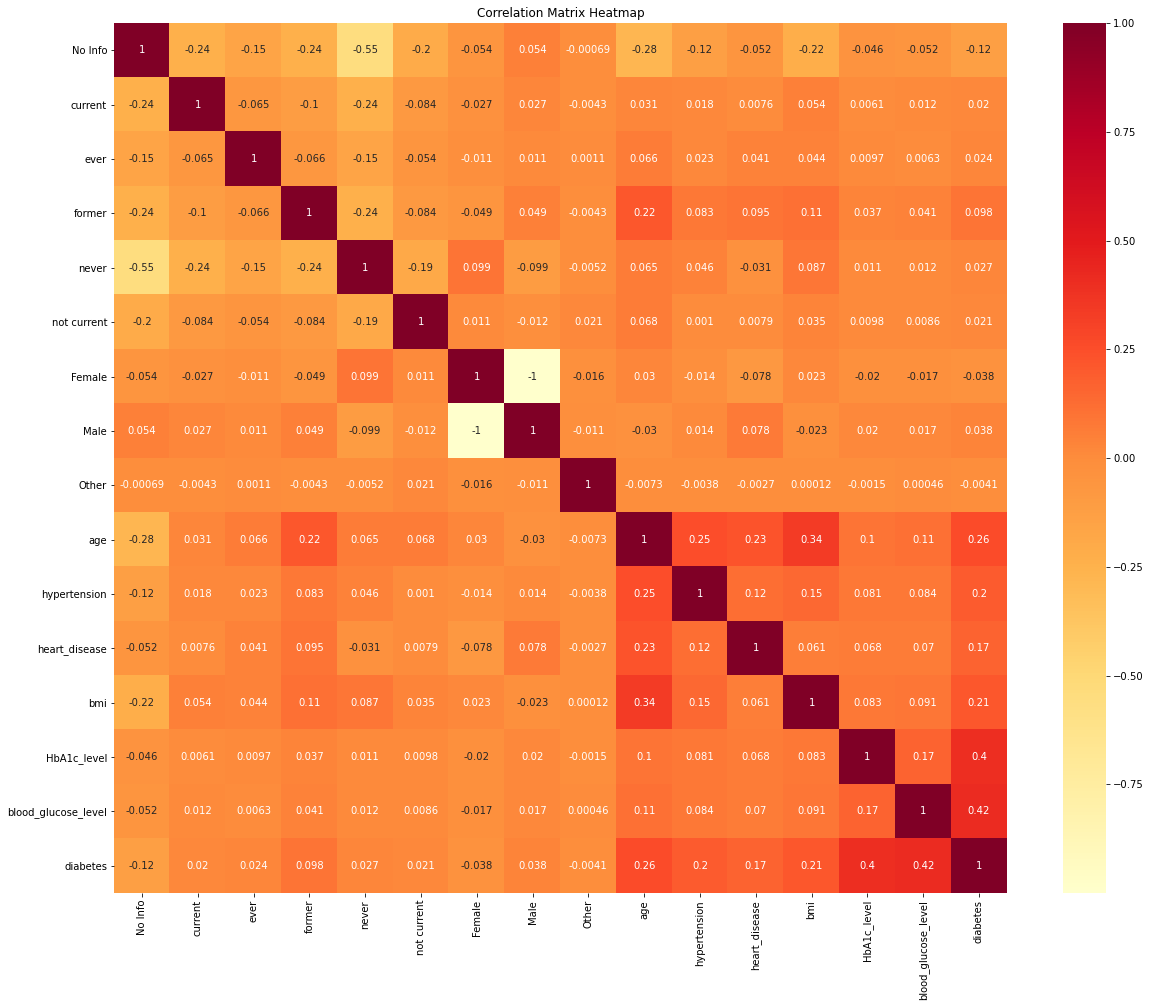

In [74]:
plt.figure(figsize=(20, 16))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlOrRd")
plt.title("Correlation Matrix Heatmap")
plt.show()

We notice that age is very correlated to hypertension, heart_disease and the bmi. We will see in the future if we can improve the model by removing those three features.

We notice that diabetes is very correlated to HbA1c_level and blood_glucose_level.




In [75]:
corr_list_with_diabetes = dict(corr_matrix['diabetes'])
corr_list_with_diabetes_sorted = {k: abs(v) for k, v in sorted(corr_list_with_diabetes.items(), key=lambda item: abs(item[1]))}

print(corr_list_with_diabetes_sorted)



{'Other': 0.004089538097798295, 'current': 0.019605505835478643, 'not current': 0.02073365805714726, 'ever': 0.024080208220788095, 'never': 0.027266862939450735, 'Female': 0.037552572852130026, 'Male': 0.03766632962961672, 'former': 0.09791730613384952, 'No Info': 0.11893878667621564, 'heart_disease': 0.17172684954885264, 'hypertension': 0.197823246408052, 'bmi': 0.21435740579951126, 'age': 0.25800803335609723, 'HbA1c_level': 0.40066031464748914, 'blood_glucose_level': 0.41955799602055627, 'diabetes': 1.0}


Now, let us look at the distribution of the dataset, . This is important to understand how it is distributed, as it will affect which cost function, which model would be more appropriate,...

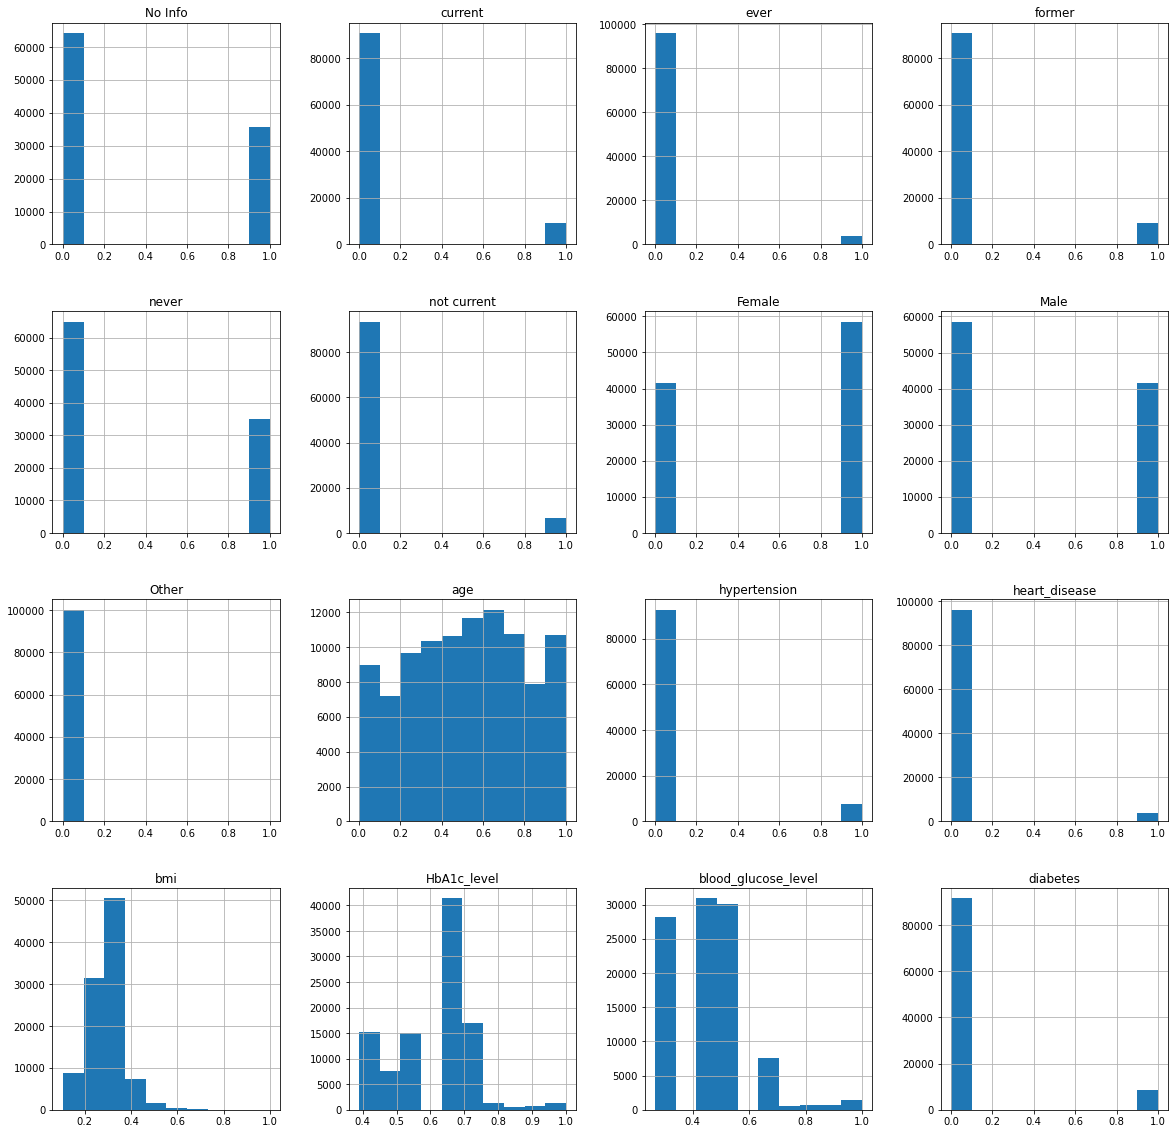

In [76]:
data.describe().T
p = data.hist(figsize = (20,20))

Here, it is extremely interesting to note that, in our dataset, the proportion of people who do not have diabetes is much more important than those who do have diabetes. Age is well distributed, so this is good because we will generalize well on people of all ages, same for gender. 

In [77]:
s = data['diabetes'].to_numpy()
print(f"We have that {sum(s)} patients have diabetes, while {len(s)-sum(s)} don't have it.")

We have that 8500.0 patients have diabetes, while 91500.0 don't have it.


Why is the above relevant? If we made a model which would systematically classify the patient as not having diabetes, we would achieve an accuracy of ~91.5%, which is good, but is clearly not what we are aiming for. The classical loss function is thus not what we might want to use.

In [78]:
s = sum(data['No Info'].to_numpy())
print(f"We have no info on the smoking habits of {s} patients.")

We have no info on the smoking habits of 35816.0 patients.


In [79]:
X = data.iloc[:,:-1]
Y = data.iloc[:,-1:]
X.head()

,No Info,current,ever,former,never,not current,Female,Male,Other,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.000,0.0,1.0,0.263246,0.733333,0.466667
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.675,0.0,0.0,0.285505,0.733333,0.266667
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.350,0.0,0.0,0.285505,0.633333,0.526667
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.450,0.0,0.0,0.245062,0.555556,0.516667
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.950,1.0,1.0,0.210471,0.533333,0.516667


In [80]:
duplicate_rows = data[data.duplicated(keep=False)]
compteur = duplicate_rows.groupby(duplicate_rows.columns.tolist()).size().to_dict()

data_no_dup = data.drop_duplicates(keep=False)


train_set, test_set = train_test_split(data_no_dup, test_size=0.25, random_state=0)
train_set, test_set = list(train_set.to_numpy()), list(test_set.to_numpy())

for (row,number) in compteur.items():
    decision  = random.randint(0, 1)
    if decision==0:
        #we had to the train set
        for _ in range(number):
            index = random.randint(0,len(train_set))
            train_set.insert(index,row)
    
    else:
        for _ in range(number):
            index = random.randint(0,len(test_set))
            test_set.insert(index,row)

train_set, test_set = np.array(train_set), np.array(test_set)

In [81]:
print(train_set.shape, test_set.shape)
print(train_set)

(73379, 16) (26621, 16)
[[0.         0.         0.         ... 0.55555556 0.42       0.        ]
 [1.         0.         0.         ... 0.67777778 0.28333333 0.        ]
 [1.         0.         0.         ... 0.55555556 0.53       0.        ]
 ...
 [1.         0.         0.         ... 0.64444444 0.66666667 0.        ]
 [0.         1.         0.         ... 0.53333333 0.28333333 0.        ]
 [1.         0.         0.         ... 0.44444444 0.26666667 0.        ]]


Let us check that we correctly implemented the test and training sets.

In [67]:
X_train = train_set[:, :-1]  
Y_train = train_set[:, -1]   

print(X_train, X_train.shape)
print(Y_train, Y_train.shape)


[[0.         0.         0.         ... 0.38833734 0.55555556 0.42      ]
 [1.         0.         0.         ... 0.20117045 0.67777778 0.28333333]
 [1.         0.         0.         ... 0.34747623 0.55555556 0.53      ]
 ...
 [1.         0.         0.         ... 0.30609259 0.64444444 0.66666667]
 [0.         1.         0.         ... 0.33253214 0.53333333 0.28333333]
 [1.         0.         0.         ... 0.34308705 0.44444444 0.26666667]] (73351, 15)
[0. 0. 0. ... 0. 0. 0.] (73351,)


In [82]:

print(f'There are {sum(Y_train)/len(Y_train) *100}% of patients with diabetes within the training set')


There are 8.602473040585677% of patients with diabetes within the training set


In [83]:
X_test = test_set[:, :-1]  
Y_test = test_set[:, -1]  

print(X_test, X_test.shape)
print(Y_test, Y_test.shape)

[[1.         0.         0.         ... 0.28550528 0.73333333 0.51666667]
 [1.         0.         0.         ... 0.21820462 0.66666667 0.53      ]
 [1.         0.         0.         ... 0.28550528 0.38888889 0.42      ]
 ...
 [0.         0.         1.         ... 0.24955586 0.53333333 0.51666667]
 [0.         0.         1.         ... 0.27442784 0.73333333 0.53333333]
 [0.         0.         1.         ... 0.31434842 0.66666667 0.26666667]] (26621, 15)
[0. 0. 0. ... 0. 0. 0.] (26621,)


In [17]:
'''
columns = ['No Info',
 'current',
 'ever',
 'former',
 'never',
 'not current',
 'Female', 'Male', 'Other',
 'age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level']


Y_test = pd.DataFrame(Y_test)
Y_test.columns = ['diabetes']

X_test = pd.DataFrame(X_test)
X_test.columns = columns


X_train = pd.DataFrame(X_train)
X_train.columns = columns

Y_train = pd.DataFrame(Y_train)
Y_train.columns = ['diabetes']


je crois c'est mieux de pas remettre sous forme de dataset parce que pour les logistic regression c'est pas pratique
dites moi si vous etes daccord

'''


Let us check that we correctly implemented the test and training sets.

In [7]:
'''isnasum = X_train.isna().sum()
print("Number of duplicates:", Y_train.duplicated().sum(), "\nNumber of NaN values:",isnasum.sum())

isnasum2 = Y_train.isna().sum()
print("Number of duplicates:", Y_train.duplicated().sum(), "\nNumber of NaN values:",isnasum2.sum()) '''

'isnasum = X_train.isna().sum()\nprint("Number of duplicates:", Y_train.duplicated().sum(), "\nNumber of NaN values:",isnasum.sum())\n\nisnasum2 = Y_train.isna().sum()\nprint("Number of duplicates:", Y_train.duplicated().sum(), "\nNumber of NaN values:",isnasum2.sum()) '

## K nearest neighbours

Let us try with different number of neighbours and plot the accuracy of the predictions. 

In [ ]:
accuracy=[]
for n in range(1,15):
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train,Y_train)
    predictions=model.predict(X_test)
    accuracy+=[accuracy_score(Y_test,predictions)]
    
plt.plot(range(1,15),accuracy)
plt.title('Accuracy of the knn method as a function of the number of neighbours')
plt.show()

The best number of neighbours to maximize accuracy seems to be 1. 

In [ ]:
model = sklearn.neighbors.KNeighborsClassifier(1)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)
conf = confusion(Y_test, y_pred, labels=['Negative', 'Positive'])

## Logistic Regression

We will now build a logistic regression model in order to predict whether an individual has diabetes or not. In our project, we are faced with a binary logistic regression, as our output variable 'diabetes' has only 2 classes. 

We start with an arbitrary value for C, the inverse of the regularization strength, and we will later explore what value of C to use in order to improve our model the most.

In [ ]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(Y_test, y_pred))

The accuracy is really high, but we can try to understand better the performance of our model. We will first use a confusion matrix which is usually used to understand how well (or bad) each category is classified. In the confusion matrix, each row represents the instances of the actual values, whereas the columns count the instances of the predicted value. 
The confusion matrix will help us understand when diabetes is correctly or incorrectly predicted or not predicted. 

In [ ]:
Y_test

In [96]:
sum(Y_test)

2190.0

In [91]:
conf = confusion(Y_test, y_pred, labels=['Negative', 'Positive'])
conf

,predicted Negative,predicted Positive
actual Negative,24229,202
actual Positive,838,1352


In [106]:
false_pos = conf.iloc[0,1]
false_neg = conf.iloc[1,0]
true_neg = conf.iloc[0,0]
true_pos = conf.iloc[1,1]

neg_inc = false_pos / (false_pos + true_neg)
pos_inc = false_neg / (false_neg + true_pos)
print(neg_inc, pos_inc)

0.008268183864761983 0.382648401826484


In [110]:
print(f'{neg_inc*100} % of the actual negatives were incorrectly predicted \n{pos_inc*100} % of the actual Positives were incorrectly predicted')

0.8268183864761982 % of the actual negatives were incorrectly predicted 
38.2648401826484 % of the actual Positives were incorrectly predicted


We see that the fraction of incorrectly predicted positives is much larger than for patients which do not have diabetes. This questions the performance of this model.
Although the accuracy is really high, the model does not perform according to this accuracy as only 62% of the patients with diabetes would be correctly predicted. This is because, as explained before, the model contains 91.5% of people without diabetes and is trained (as checked previously) on a dataset with only 8.6% of ill patients. We are faced with a problem of imbalanced classification. 

As we said, the problem with our dataset is that it is imbalanced, so looking at the accuracy is not enough. This invites us to look at other metrics, in particular the F1 and F2 Scores which look at the precision and recall metrics: 
Precision counts the number of positives that are correct within all the data that has been predicted as positive. Its formula is given by: $$\text{precision} = \frac{\text{# of True positives}}{\text{# of True positives}+\text{# of False positives}} $$

Recall counts the number of positives that the model has succeeded to find, within everything that is actually positive. (This is what we computed earlier with the confusion matrix). Its formula is: $$\text{recall} = \frac{\text{# of True positives}}{\text{# of True positives}+\text{# of False negatives}} $$

Ideally, we would want a high recall and a high precision, but there exists a tradeoff between both, which is why we will look at the F1 and F2 Scores. F1 being the harmonic mean of both and F2 being the weighted harmonic mean of both. The formula of F1 is: $$ \text{F}1 = 2\times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$ and the one for F2, which comes from the $\text{F}_\beta$ is:
$$ \text{F}2 = (1+2^2)\times \frac{\text{precision} \times \text{recall}}{(2^2\cdot\text{precision}) + \text{recall}}$$

The reason why we are also interested in the F2 score and not only F1, is because it places more importance on the recall, ie on giving a correct prediction to patients with diabetes. In our case, this is more valuable than the precision. A high precision means that we did not have many false positives, ie that we did not incorrectly tell patients which don't have diabetes that they have diabetes, whereas a high recall means that we did not incorrectly tell people with diabetes that they do not have diabetes. In our case, the latter is much more important.

In [8]:
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
f2 = fbeta_score(Y_test, y_pred, beta=2)
print(f'In the simple logistic regression: \nThe precision score is {precision} \nThe recall score is {recall} \nThe F1 Score is {f1} \nThe F2 Score is {f2}')

NameError: name 'Y_test' is not defined

The F1 Score is already pretty good, but the F2 Score not really. We will look at two other ways to face the problem of umbalanced data: cross-validation and resampling, both using other metrics than accuracy.

This invites us to calculate the F1 Score, and implementing an implicit cost matrix which we will seek to optimize

### Solving Imbalanced data through cross-validation and hyper-parameter tuning  (using the F1 and F2 Score)

We find that the optimal parameter for C is C=100. We will now find the best number of folds using this value for the hyperparameter. To do this, we will first look at the best hyperparameter c that optimizes our model's performance, with the f1 score. Then, we will iterate through a range of possible values for k, train the classifier with this C, and test our data to compute the resulting f1_scores. This will give uss the best number of folds for which we achieve the highest F1 Score.

In [ ]:
classifier = LogisticRegression(max_iter=1000)
scoring1 = make_scorer(f1_score) 
scoring2 = make_scorer(fbeta_score, beta=2)
param_grid = {"C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid1 = GridSearchCV(classifier, param_grid, scoring=scoring1, cv=5)
grid1.fit(X_train, Y_train)

grid2 = GridSearchCV(classifier, param_grid, scoring=scoring2, cv=5)
grid2.fit(X_train, Y_train)

best_estimator1 = grid1.best_estimator_
best_estimator2 = grid2.best_estimator_
best_f1_score = grid1.best_score_
best_f2_score = grid2.best_score_

print(f'The best estimator found with F1 scoring is: {best_estimator1}')
print(f'The best estimator found with F2 scoring is: {best_estimator2}')
print(f'The best F1 Score we got was: {best_f1_score}')
print(f'The best F2 Score we got was: {best_f2_score}')

In [ ]:
results1_df = pd.DataFrame(grid1.cv_results_)
results2_df = pd.DataFrame(grid2.cv_results_)
C_values = param_grid['C']
plt.figure(figsize=(10, 6))
plt.plot(C_values, results1_df['mean_test_score'], marker='o', linestyle='-', label='Mean F1 Score')
plt.plot(C_values, results2_df['mean_test_score'], marker='o', linestyle='-', label='Mean F2 Score')
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Grid Search Results')
plt.legend()
plt.show()

In both cases (optimizing wrt the F1 or F2 metric), the best hyperparameter C is 100. We will now perform cross validation with this C. We will remove the duplicates to avoid any potential data leaks and testing on the same data as the training one.

In [ ]:
nodup = data.drop_duplicates()
X_nodup = nodup.iloc[:,:-1].to_numpy()
Y_nodup = nodup.iloc[:,-1:].to_numpy()
print(X_nodup, Y_nodup)
print(X_nodup.shape, Y_nodup.shape)

In [ ]:
f1_scores = {}
f2_scores = {}
k_values = range(2, 12)

classifier_cv = best_estimator1 #choosing the first or second is the same because in both cases
for k in k_values:
    scores_f1 = cross_val_score(classifier_cv, X_nodup, Y_nodup.reshape(96146), cv=k, scoring=make_scorer(f1_score))
    scores_f2 = cross_val_score(classifier_cv, X_nodup, Y_nodup.reshape(96146), cv=k, scoring=make_scorer(fbeta_score, beta=2))
    f1_scores[k] = scores_f1.mean()
    f2_scores[k] = scores_f2.mean()

best_k_f1 = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[best_k_f1]

best_k_f2 = max(f2_scores, key=f2_scores.get)
best_f2_score = f2_scores[best_k_f2]

print(f1_scores)
print(f'The best number of folds for F1 score is: {best_k_f1}')
print(f"The best F1 score achieved: {best_f1_score}")

print(f"The best number of folds (k) for F2 score: {best_k_f2}")
print(f"The best F2 score achieved: {best_f2_score}")

Unfortunately, cross validation does not improve the f1 nor the f2 score very much, which we could've predicted. We will now try the resampling method, which should be more adapted for dealing with unbalanced data.

### Solving Imbalanced data through resampling 

We will now use the resampling technique, which consists of either undersampling, or oversampling. Undersampling results in randomly selecting instances from the majority class, the negative class (patients without diabetes), and removing them from the dataset. On the other hand, Oversampling involves generating synthetic samples in the minority class to increase its representation. However, both of these methods have some cons: undersampling may remove valuable information, while undersampling may generate data that does not accurately represent the distribution of the minority class. We will test out both methods and analyse the results. 

In [9]:
Y_pd = pd.DataFrame(Y_train)
Y_pd.hist(figsize = (8,6))

NameError: name 'Y_train' is not defined

#### Oversampling
For Over Sampling, we use the imbalanced-learn built in Synthetic Minority Oversampling Technique (SMOTE), this one resamples our data synthetically so that the minority data is duplicated to reach the same number as the majority data. SMOTE works using the kNN method, it selects a random sample from the minority class, finds its k-nearest neighbors and selects a random one. Then generates synthetic sample between the sample and the neighbor, by computing a linear combination of the difference between their features. 

In [ ]:
smote = SMOTE(random_state = 101)
X_train_os, Y_train_os = smote.fit_resample(X_train, Y_train)
Y_os_pd = pd.DataFrame(Y_train_os)
Y_os_pd.hist(figsize=(8,6))

plt.xlabel('Values of our resampled Y_train')
plt.ylabel('Number of instances')

plt.show()

In [ ]:
classifier_os = LogisticRegression(max_iter=1000)
classifier_os.fit(X_train_os, Y_train_os)

y_pred_os = classifier_os.predict(X_test)

In [ ]:
conf_os = confusion(Y_test, y_pred_os, labels=['Negative', 'Positive'])
f1, recall, precision = f1_score(Y_test, y_pred_os), recall_score(Y_test, y_pred_os), precision_score(Y_test, y_pred_os)
f2 = fbeta_score(Y_test, y_pred_os, beta=5)
print(f'The resulting accuracy is {accuracy_score(Y_test, y_pred_os)}')
print(f'The resulting recall score is: {recall}\nThe resulting precision score is: {precision}\nThe resulting F1 score is: {f1} \nThe resulting F2 score is: {f2}')
conf_os

#### Undersampling
We start by importing RandomUnderSampler from Imbalanced-learn. We then resample our training set with the built in fit_resample method. We only do this with the training data and not the test data as the test data is supposed to represent how the real world would be. It would thus be bad practice to modify it, as it would bias the reliability of our evaluation.

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_us, Y_train_us = rus.fit_resample(X_train, Y_train)
Y_us_pd = pd.DataFrame(Y_train_us)
Y_us_pd.hist(figsize=(8,6))

plt.xlabel('Values of our resampled Y_train')
plt.ylabel('Number of instances')

plt.show()

We now train this new training set with Logistic Regression, run a prediction and see how this performs.

In [ ]:
classifier_us = LogisticRegression(max_iter=1000)
classifier_us.fit(X_train_us, Y_train_us)
y_pred_us = classifier_us.predict(X_test)
conf_us = confusion(Y_test, y_pred_us, labels=['Negative', 'Positive'])
f1, recall, precision = f1_score(Y_test, y_pred_us), recall_score(Y_test, y_pred_us), precision_score(Y_test, y_pred_us)
f2 = fbeta_score(Y_test, y_pred_us, beta=5)
print(conf_us, '\n')
print(f'The resulting accuracy is {accuracy_score(Y_test, y_pred_us)}')
print(f'The resulting recall score is: {recall}\nThe resulting precision score is: {precision}\nThe resulting F1 score is: {f1} \nThe resulting F2 score is: {f2}')
conf_us

This is good news! We have achieved a model with high accuracy: 89%, and a high F2 score, the F1 score is lower as the one we had initially, but as we explained previously, our aim in this project is to give an accurate prediction to patients who have diabetes (which is what F2 places more importance on). We have successfully improved our model according to our goal.  